In [1]:
import numpy as np
import pandas as pd

rf = .02
price0 = 100
sigma = .08
runs = 10000
periods = 252

#Build a function to wrap everything in a function
def simulate_returns(price0, rf, periods, sigma, runs, time_step = 1/252):
    returns = pd.DataFrame(np.random.normal(0,1, periods * runs).reshape(periods, runs))
    returns = returns * sigma * time_step ** .5 + (rf - .5 * sigma ** 2) * time_step
    returns = np.exp(returns).cumprod()
    returns.index = returns.index + 1
    returns.loc[0] = 1
    returns = returns.sort_index()
    paths = returns * price0
    return paths
paths = simulate_returns(price0, rf, periods, sigma, runs)
print(paths)

           0           1           2           3           4           5     \
0    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1     99.966665   99.425143   99.914340   99.708939  100.494872  100.318072   
2    101.385463   99.498752  100.117623   99.888857   99.791112  100.130438   
3    100.768541   98.802204  100.258291  100.495182   98.765644  101.338648   
4    100.619144  100.012657  100.193247  100.623248   98.860805  100.992338   
..          ...         ...         ...         ...         ...         ...   
248  117.099143   99.233216  106.420324   92.503594   92.579106   86.397850   
249  116.988917   99.929758  106.042096   93.039780   92.241943   85.943507   
250  116.803576   99.450250  105.973212   92.232670   93.039394   86.140186   
251  115.930483   99.090745  105.398322   92.405163   92.931894   85.796868   
252  115.379298   98.313780  106.719553   92.236164   93.155579   85.162983   

           6           7           8           9   

In [2]:
from ipywidgets import interact_manual
from ipywidgets import widgets

#Create widgets
rf = widgets.FloatSlider(value=.02,
                          min=.01,
    max=.10,
                      step=.001,
                        description='Risk-free Rate:',
                            readout_format='.1%'
)

price0 = widgets.IntSlider(value=100,
                          min=1,
    max=1000,
                              step = 10,
                              description='Price:'
)

sigma = widgets.FloatSlider(value=.08,
                          min=.01,
    max=.40,
                      step=.001,
                        description='Sigma:',
                            readout_format='.1%'
)

runs = widgets.IntSlider(value=10000,
                          min=1,
    max=1000000,
                              step = 10,
                              description='Runs:'
)

periods = widgets.IntSlider(value=252,
                          min=10,
    max=504,
                              step = 10,
                              description='Periods:'
)

#Create data dictionary
data_dictionary = {}

#Modify the formula so that the data dictionary is modified
def simulate_returns(price0, rf, periods, sigma, runs, time_step = 1/252):
    returns = pd.DataFrame(np.random.normal(0,1, periods * runs).reshape(periods, runs))
    returns = returns * sigma * time_step ** .5 + (rf - .5 * sigma ** 2) * time_step
    returns = np.exp(returns).cumprod()
    returns.index = returns.index + 1
    returns.loc[0] = 1
    returns = returns.sort_index()
    paths = returns * price0
    data_dictionary['Data'] = paths
    print("Data Updated")
    
#To set the data you need to make sure you click the Run Interact button
interact_manual(simulate_returns, price0=price0, periods=periods, rf=rf, sigma=sigma, runs=runs,
               time_step = widgets.fixed(1/252));

interactive(children=(IntSlider(value=100, description='Price:', max=1000, min=1, step=10), FloatSlider(value=…

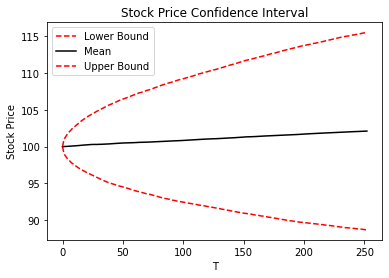

In [3]:
import matplotlib.pyplot as plt

#Create a function which draws paths with confidence intervals
def draw_paths(paths):
    df = pd.concat([paths.mean(axis=1) - paths.std(axis=1) * 1.645,
    paths.mean(axis=1),
    paths.mean(axis=1) + paths.std(axis=1) * 1.645], axis=1)
    df.columns = ['Lower Bound', 'Mean', 'Upper Bound']
    plt.plot(df.index, df['Lower Bound'].values, color='red', linestyle='--')
    plt.plot(df.index, df['Mean'].values, color='black')
    plt.plot(df.index, df['Upper Bound'].values, color='red', linestyle='--')
    plt.xlabel("T")
    plt.ylabel("Stock Price")
    plt.legend(['Lower Bound', 'Mean','Upper Bound'])
    plt.title("Stock Price Confidence Interval")
    plt.show()
draw_paths(data_dictionary['Data'])

In [4]:
#Update the formula to graph the path after data is run
def simulate_returns(price0, rf, periods, sigma, runs, time_step = 1/252):
    returns = pd.DataFrame(np.random.normal(0,1, periods * runs).reshape(periods, runs))
    returns = returns * sigma * time_step ** .5 + (rf - .5 * sigma ** 2) * time_step
    returns = np.exp(returns).cumprod()
    returns.index = returns.index + 1
    returns.loc[0] = 1
    returns = returns.sort_index()
    paths = returns * price0
    data_dictionary['Data'] = paths
    draw_paths(paths)
    
#Once again, make sure the click the button
interact_manual(simulate_returns, price0=price0, periods=periods, rf=rf, sigma=sigma, runs=runs,
               time_step = widgets.fixed(1/252));

interactive(children=(IntSlider(value=100, description='Price:', max=1000, min=1, step=10), FloatSlider(value=…

In [5]:
strike1 = 90
strike2 = 95
strike3 = 100

#Build a function to find the payoff distribution for three calls with different strike prices
#Remember that you have to discount them for time value of money
def call_payoffs(strike1, strike2, strike3, periods, rf):
    time_step = 1/252
    paths = data_dictionary['Data']
    payoffs1 = paths.iloc[-1].apply(lambda x: max(x-strike1, 0)) / np.exp(time_step * periods * rf)
    payoffs2 = paths.iloc[-1].apply(lambda x: max(x-strike2, 0)) / np.exp(time_step * periods * rf)
    payoffs3 = paths.iloc[-1].apply(lambda x: max(x-strike3, 0)) / np.exp(time_step * periods * rf)

    payoffs = pd.concat([payoffs1, payoffs2, payoffs3], axis=1)
    payoffs.columns = ["Call Strike {}".format(strike1),
                      "Call Strike {}".format(strike2),
                      "Call Strike {}".format(strike3)]
    return payoffs

#You will give the current value of the periods and rf widgets so that the two dashboards are aligned
payoffs = call_payoffs(strike1, strike2, strike3, periods.value, rf.value)
print(payoffs.head(5))

   Call Strike 90  Call Strike 95  Call Strike 100
0        3.850281        0.000000         0.000000
1        7.342183        2.441189         0.000000
2       13.745594        8.844601         3.943607
3       11.243289        6.342296         1.441302
4        0.000000        0.000000         0.000000


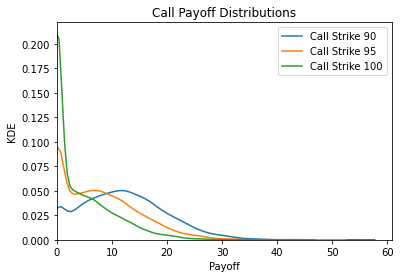

In [6]:
import seaborn as sns

#Build out kernel density estimations
sns.kdeplot(payoffs.iloc[:,0].values, label="Call Strike {}".format(strike1))
sns.kdeplot(payoffs.iloc[:,1].values, label="Call Strike {}".format(strike2))
sns.kdeplot(payoffs.iloc[:,2].values, label="Call Strike {}".format(strike3))
plt.xlabel("Payoff")
plt.ylabel("KDE")
plt.title("Call Payoff Distributions")
plt.xlim(0, plt.xlim()[1])
plt.show()

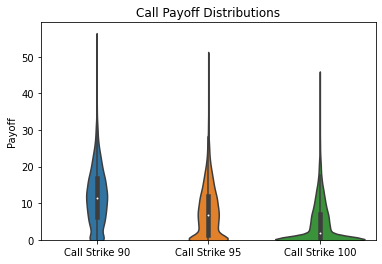

In [7]:
#Create a violin plot
sns.violinplot(data=payoffs)
plt.ylim([0, plt.ylim()[1]])
plt.ylabel("Payoff")
plt.title("Call Payoff Distributions")
plt.show()

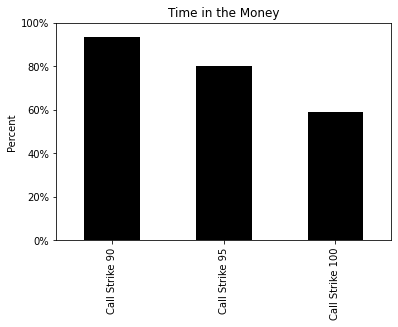

In [8]:
from matplotlib.ticker import PercentFormatter 

#Plot the percent of the runs that are in the money by the end
ax = (payoffs > 0).mean().plot(kind='bar', color='black')
plt.ylim([0,1])
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.title("Time in the Money")
plt.ylabel("Percent")

plt.show()

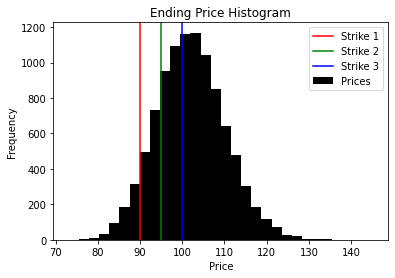

In [9]:
#Build a histogram of the ending prices with the strike prices represented with vertical lines
paths = data_dictionary['Data']
paths.iloc[-1].plot.hist(bins=30, color='black',label='Prices')
plt.axvline(strike1,color='red', label='Strike 1')
plt.axvline(strike2,color='green', label='Strike 2')
plt.axvline(strike3,color='blue', label='Strike 3')
plt.legend()
plt.xlabel('Price')
plt.title("Ending Price Histogram")
plt.show()

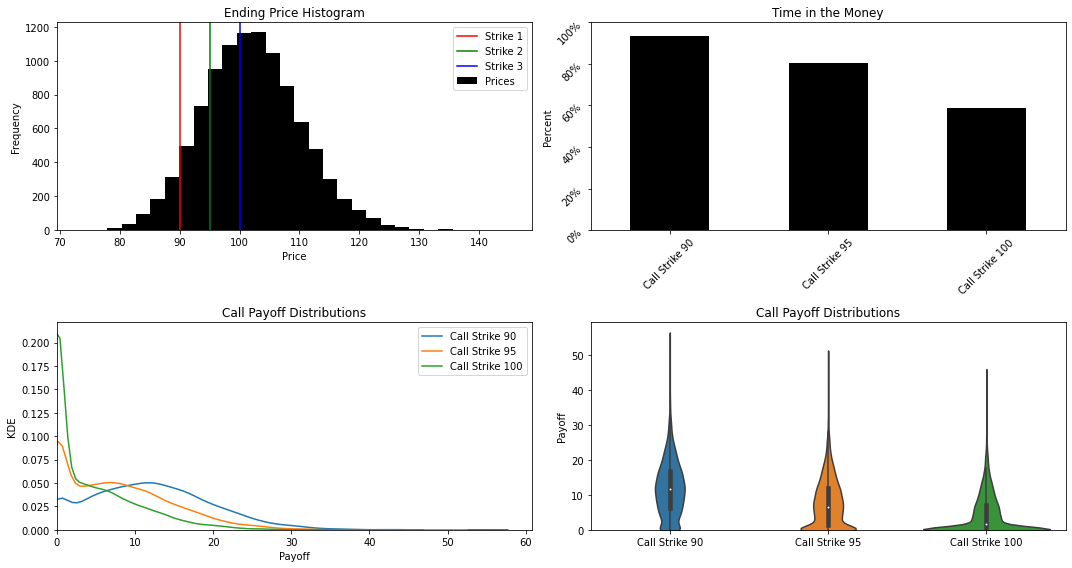

In [10]:
#Build a function to graph call option visualization
def graph_call_options(payoffs, strike1, strike2, strike3):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
    paths = data_dictionary['Data']
    paths.iloc[-1].plot.hist(bins=30, color='black',label='Prices', ax=ax[0][0])
    ax[0][0].axvline(strike1,color='red', label='Strike 1')
    ax[0][0].axvline(strike2,color='green', label='Strike 2')
    ax[0][0].axvline(strike3,color='blue', label='Strike 3')
    ax[0][0].legend()
    ax[0][0].set_xlabel('Price')
    ax[0][0].set_title("Ending Price Histogram")

    (payoffs > 0).mean().plot(kind='bar', ax=ax[0][1], color='black')
    ax[0][1].set_ylim([0,1])
    ax[0][1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax[0][1].set_title("Time in the Money")
    ax[0][1].set_ylabel("Percent")
    ax[0][1].tick_params(labelrotation=45)

    sns.kdeplot(payoffs.iloc[:,0].values, label="Call Strike {}".format(strike1),ax=ax[1][0])
    sns.kdeplot(payoffs.iloc[:,1].values, label="Call Strike {}".format(strike2),ax=ax[1][0])
    sns.kdeplot(payoffs.iloc[:,2].values, label="Call Strike {}".format(strike3),ax=ax[1][0])

    ax[1][0].set_xlabel("Payoff")
    ax[1][0].set_ylabel("KDE")
    ax[1][0].set_title("Call Payoff Distributions")
    ax[1][0].set_xlim(0, ax[1][0].get_xlim()[1])

    sns.violinplot(data=payoffs, ax=ax[1][1])
    ax[1][1].set_ylim([0, ax[1][1].get_ylim()[1]])
    ax[1][1].set_ylabel("Payoff")
    ax[1][1].set_title("Call Payoff Distributions")

    fig.tight_layout()
    plt.show()
graph_call_options(payoffs, strike1, strike2, strike3)

In [11]:
from ipywidgets import interact, fixed

#Make a dashboard function to both find the payoffs and also create the graphs
def call_dashboard(strike1, strike2, strike3, periods, rf):
    payoffs = call_payoffs(strike1, strike2, strike3, periods, rf)
    graph_call_options(payoffs, strike1, strike2, strike3)

strike1 = widgets.IntSlider(value=90,
                          min=1,
    max=1000,
                              step = 10,
                              description='Strike 1:'
)

strike2 = widgets.IntSlider(value=95,
                          min=1,
    max=1000,
                              step = 10,
                              description='Strike 2:'
)

strike3 = widgets.IntSlider(value=100,
                          min=1,
    max=1000,
                              step = 10,
                              description='Strike 3:'
)


interact(call_dashboard, strike1=strike1,
         strike2=strike2, strike3=strike3,
         periods=fixed(periods.value), rf=fixed(rf.value));

interactive(children=(IntSlider(value=90, description='Strike 1:', max=1000, min=1, step=10), IntSlider(value=…

In [12]:
#For ease of use, pull grab the dashboard for simulating returns
interact_manual(simulate_returns, price0=price0, periods=periods, rf=rf, sigma=sigma, runs=runs,
               time_step = widgets.fixed(1/252));

interactive(children=(IntSlider(value=100, description='Price:', max=1000, min=1, step=10), FloatSlider(value=…

In [13]:
#And then down here put the call option dashboard
strike1 = widgets.IntSlider(value=90,
                          min=1,
    max=1000,
                              step = 10,
                              description='Strike 1:'
)

strike2 = widgets.IntSlider(value=95,
                          min=1,
    max=1000,
                              step = 10,
                              description='Strike 2:'
)

strike3 = widgets.IntSlider(value=100,
                          min=1,
    max=1000,
                              step = 10,
                              description='Strike 3:'
)

interact(call_dashboard, strike1=strike1,
         strike2=strike2, strike3=strike3,
         periods=fixed(periods.value), rf=fixed(rf.value));

interactive(children=(IntSlider(value=90, description='Strike 1:', max=1000, min=1, step=10), IntSlider(value=…